In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from config import N_HAND_LANDMARKS, N_POSE_LANDMARKS, UPPER_BODY_CONNECTIONS
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

## 0. Preparing testing example

In [2]:
import cv2
import keypoint_extract as md

source_path = "../notebooks/dataset/videos/D0014.mp4"
image_dir = "../notebooks/dataset/visualization/images"

# Capture video frames as images
cap = cv2.VideoCapture(source_path)
os.makedirs(image_dir, exist_ok=True)
print("Capture video frames processing...")
frame_id = 0
while True:
    ret, frame = cap.read()
    if not ret:
        frame_id += 1
        break
    save_path = os.path.join(image_dir, f"frame_{frame_id}.jpg")
    cv2.imwrite(save_path, frame)
    print(f"Saved: {save_path}")
    frame_id += 1
cap.release()
print("Done saving frames")

Capture video frames processing...
Saved: ../notebooks/dataset/visualization/images/frame_0.jpg
Saved: ../notebooks/dataset/visualization/images/frame_1.jpg
Saved: ../notebooks/dataset/visualization/images/frame_2.jpg
Saved: ../notebooks/dataset/visualization/images/frame_3.jpg
Saved: ../notebooks/dataset/visualization/images/frame_4.jpg
Saved: ../notebooks/dataset/visualization/images/frame_5.jpg
Saved: ../notebooks/dataset/visualization/images/frame_6.jpg
Saved: ../notebooks/dataset/visualization/images/frame_7.jpg
Saved: ../notebooks/dataset/visualization/images/frame_8.jpg
Saved: ../notebooks/dataset/visualization/images/frame_9.jpg
Saved: ../notebooks/dataset/visualization/images/frame_10.jpg
Saved: ../notebooks/dataset/visualization/images/frame_11.jpg
Saved: ../notebooks/dataset/visualization/images/frame_12.jpg
Saved: ../notebooks/dataset/visualization/images/frame_13.jpg
Saved: ../notebooks/dataset/visualization/images/frame_14.jpg
Saved: ../notebooks/dataset/visualization/ima

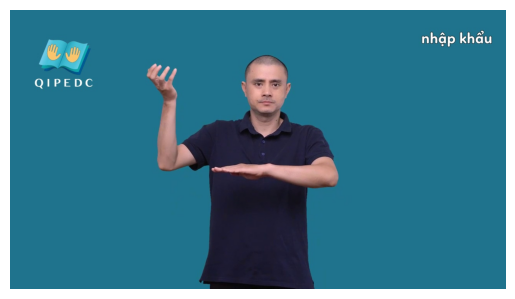

In [3]:
image = cv2.imread("../notebooks/dataset/visualization/images/frame_57.jpg")

def display_image(image, axis=False, grid=False, alpha=1):
    """Plot image with matplotlib and cv2."""
    
    plt.figure()
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), alpha=alpha)
    if not axis:
        plt.axis('off')
    if grid:
        plt.grid()
    plt.show()
    
display_image(image)

In [4]:
def add_keypoints_to_image(image, list_landmarks, color=(0, 255, 0)):
    """Plot image with keypoints."""
    
    image_height, image_width, _ = image.shape
    for (x, y, _) in list_landmarks:
        if x != 0 and y != 0:
            px = int(x * image_width)
            py = int(y * image_height)
            cv2.circle(image, (px, py), 4, color, -1)

red, blue, green = (0, 0, 255), (255, 0, 0), (0, 255, 0)

## 1. Extract keypoints

### 1.1 For image (one frame)

In [5]:
# def extract_keypoints(results, visibility_thres=0.5):
#     """Extract all keypoints from one video frame."""
    
#     # Upper pose
#     pose_landmarks = []
#     if results.pose_landmarks:
#         landmarks = results.pose_landmarks.landmark
#         for idx, i in enumerate(UPPER_BODY_CONNECTIONS):
#             if i < len(landmarks):
#                 res = landmarks[i]
#                 if res.visibility < visibility_thres:
#                     pose_landmarks.append([0.0, 0.0, 0.0])
#                 else:
#                     pose_landmarks.append([res.x, res.y, res.z])
#     else:
#         pose_landmarks = [[0.0, 0.0, 0.0]] * N_POSE_LANDMARKS
    
#     # Left hand
#     if results.left_hand_landmarks:
#         left_hand_landmarks = [[lm.x, lm.y, lm.z] for lm in results.left_hand_landmarks.landmark]
#     else:
#         left_hand_landmarks = [[0.0, 0.0, 0.0]] * N_HAND_LANDMARKS

#     # Right hand
#     if results.right_hand_landmarks:
#         right_hand_landmarks = [[lm.x, lm.y, lm.z] for lm in results.right_hand_landmarks.landmark]
#     else:
#         right_hand_landmarks = [[0.0, 0.0, 0.0]] * N_HAND_LANDMARKS
    
#     return pose_landmarks, left_hand_landmarks, right_hand_landmarks

In [6]:
import keypoint_extract as md
import mediapipe as mp

mp_holistic = mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)

I0000 00:00:1761279449.746914  164731 gl_context.cc:369] GL version: 2.1 (2.1 INTEL-20.7.3), renderer: Intel(R) Iris(TM) Plus Graphics 640


In [7]:
_, results = md.mediapipe_detection(image, mp_holistic)
print(results)
pose_landmarks, left_hand_landmarks, right_hand_landmarks = md.extract_keypoints(results)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


<class 'mediapipe.python.solution_base.SolutionOutputs'>


W0000 00:00:1761279450.110934  165132 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761279450.174561  165130 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761279450.195011  165129 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761279450.199006  165130 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761279450.206720  165132 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761279450.219218  165131 landmark_projection_calculator.cc:186] Using NORM_RE

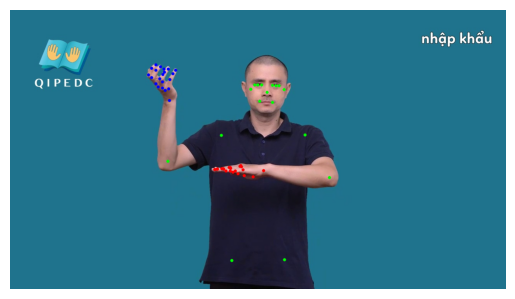

In [8]:
add_keypoints_to_image(image, pose_landmarks, color=green)
add_keypoints_to_image(image, left_hand_landmarks, color=red)
add_keypoints_to_image(image, right_hand_landmarks, color=blue)
display_image(image)

### 1.2 For video

In [9]:
def get_list_frame(source_path):
    """Extract keypoints sequences from one video."""
    
    frames_keypoints = []
    cap = cv2.VideoCapture(source_path)
    while cap.isOpened():
        # read video frame
        success, image = cap.read()

        # skip empty frames
        if not success:
            break
        
        # MediaPipe Holistic processing
        _, results = md.mediapipe_detection(image, mp_holistic)
        pose_landmarks, left_hand_landmarks, right_hand_landmarks = md.extract_keypoints(results)
        
        frames_keypoints.append([left_hand_landmarks, right_hand_landmarks, pose_landmarks])
    cap.release()
    return frames_keypoints
    
def concate_array(left_hand_landmarks, right_hand_landmarks, pose_landmarks):
    """ """
    
    a1 = np.array(left_hand_landmarks).reshape(-1)
    a2 = np.array(right_hand_landmarks).reshape(-1)
    a3 = np.array(pose_landmarks).reshape(-1)
    result = np.concatenate((a1, a2, a3), axis=None)
    return result

def check_zeros(list_landmarks):
    data = np.array(list_landmarks)
    if np.all(data == 0):
        return True
    return False

In [10]:
try:
    list_fr = get_list_frame(source_path)
    X = []
    list_idx = []
    for i in range(len(list_fr)):
        if not check_zeros(list_fr[i][0]) or not check_zeros(list_fr[i][1]):
            X.append(concate_array(list_fr[i][0], list_fr[i][1], list_fr[i][2]))
            list_idx.append(i)
    
    # filtering frame
    X_new = np.array(X)
    K = 20
    kmeans = KMeans(n_clusters=K, random_state=42)
    kmeans.fit(X_new)
    cluster_centers = kmeans.cluster_centers_
    distances = cdist(X_new, cluster_centers, 'euclidean')  # d[i][j]: distance from frame i to cluster center j
    nearest_indies = np.argmin(distances, axis=0)                 
    index = np.sort(nearest_indies)
    print(index)
    data = []
    for i in index:
        data.append(list_fr[list_idx[i]])
    data_save = np.asarray(data, dtype="object")

except Exception as e:
    print(f"error write: {e}")

[ 0  2  5  7  9 11 12 14 16 29 35 39 55 62 64 65 66 67 68 73]


Frame 0 (Frame 1 in video):


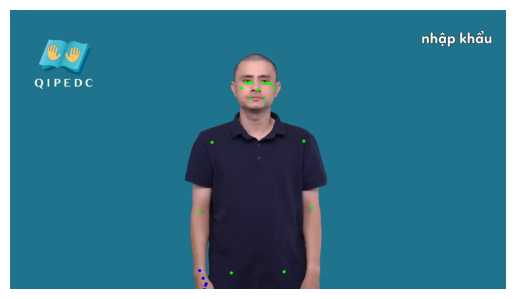

Frame 1 (Frame 34 in video):


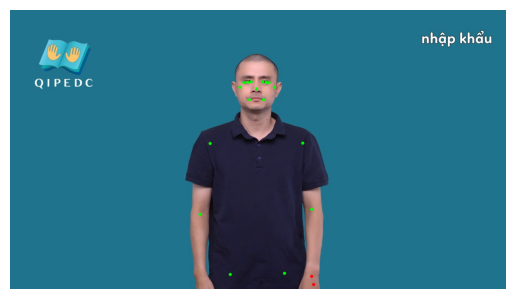

Frame 2 (Frame 38 in video):


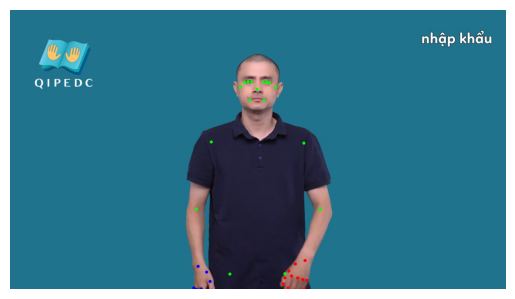

Frame 3 (Frame 40 in video):


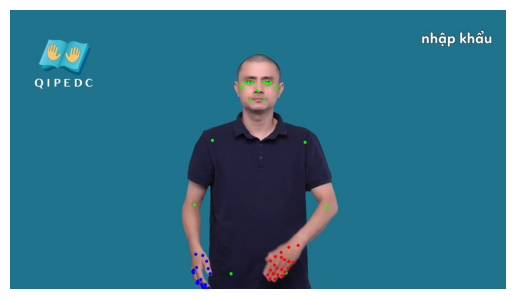

Frame 4 (Frame 42 in video):


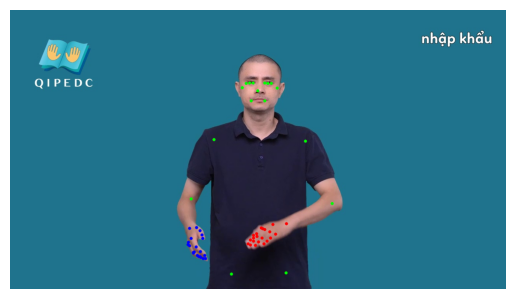

Frame 5 (Frame 44 in video):


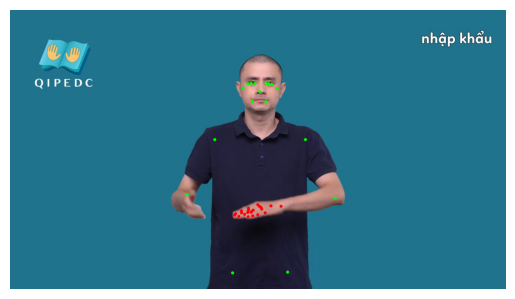

Frame 6 (Frame 45 in video):


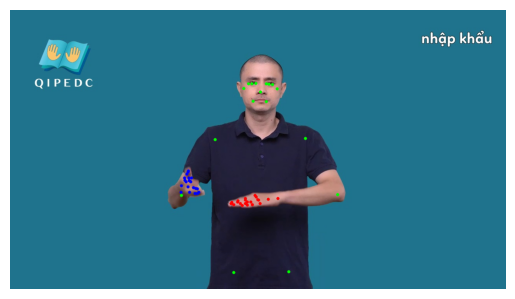

Frame 7 (Frame 47 in video):


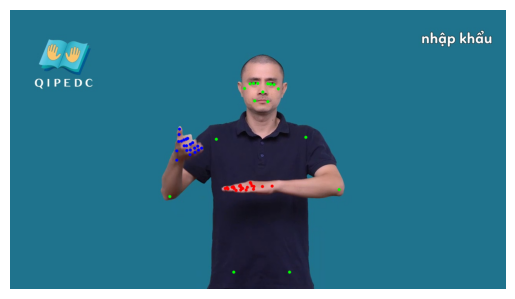

Frame 8 (Frame 49 in video):


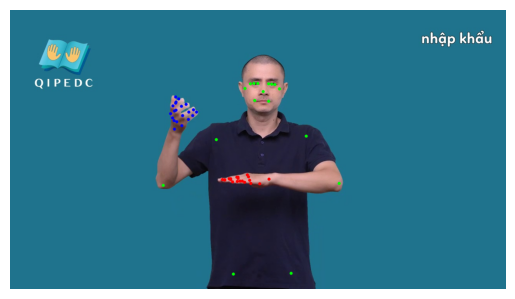

Frame 9 (Frame 62 in video):


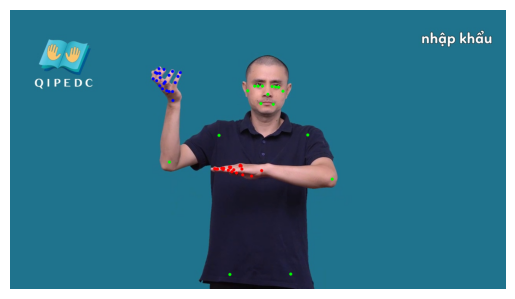

Frame 10 (Frame 68 in video):


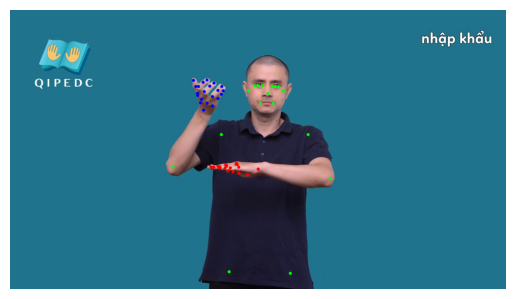

Frame 11 (Frame 72 in video):


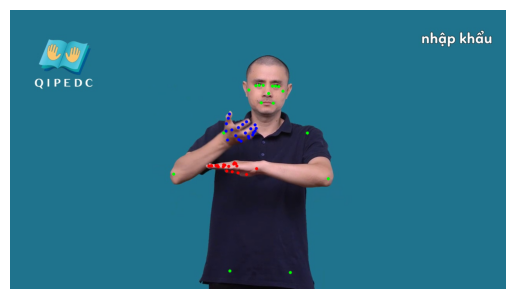

Frame 12 (Frame 88 in video):


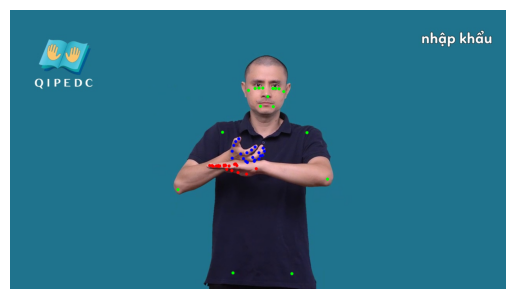

Frame 13 (Frame 95 in video):


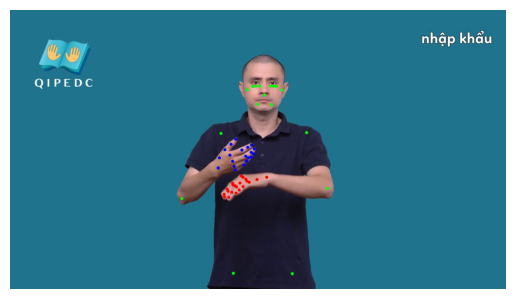

Frame 14 (Frame 97 in video):


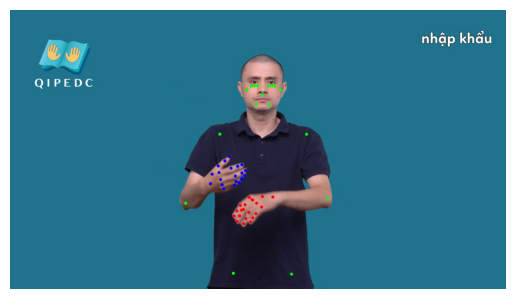

Frame 15 (Frame 98 in video):


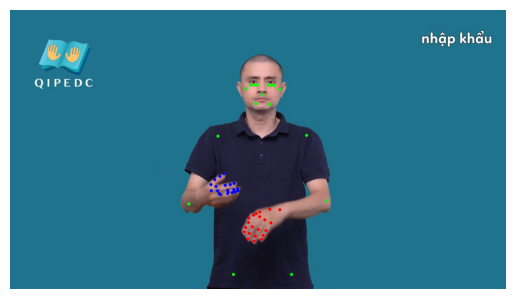

Frame 16 (Frame 99 in video):


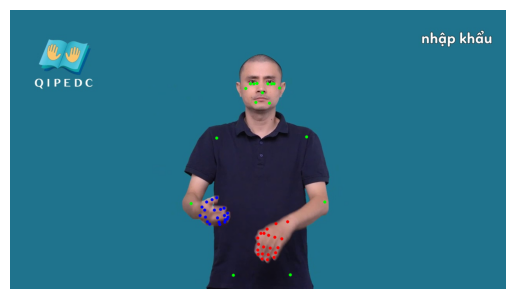

Frame 17 (Frame 100 in video):


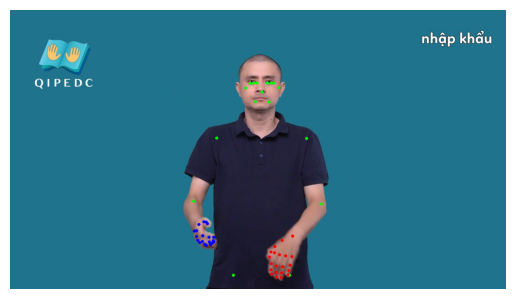

Frame 18 (Frame 101 in video):


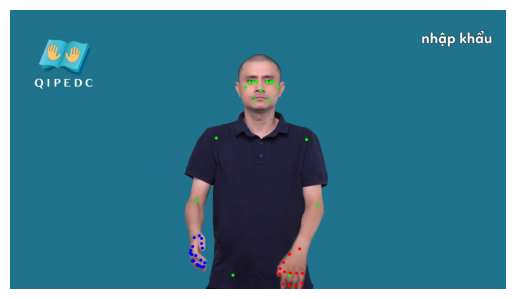

Frame 19 (Frame 106 in video):


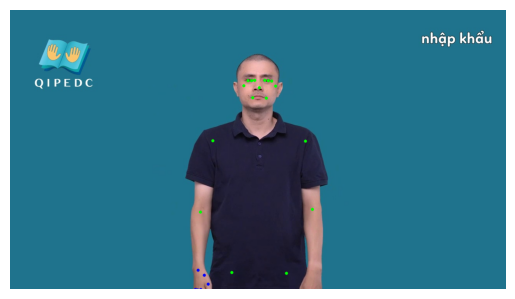

In [11]:
for i, (lh, rh, pose) in enumerate(data_save):
    idx = index[i]
    print(f"Frame {i} (Frame {list_idx[idx]} in video):")
    image = cv2.imread(f"../notebooks/dataset/visualization/images/frame_{list_idx[idx]}.jpg")

    add_keypoints_to_image(image, pose, color=green)
    add_keypoints_to_image(image, lh, color=red)
    add_keypoints_to_image(image, rh, color=blue)

    display_image(image)


In [12]:
np.save(os.path.join("../notebooks/dataset/visualization/", "0.npy"), data_save)

In [13]:
data_save.shape

(20, 3)

In [14]:
frame_0 = data_save[0]
print(f"Left-hand landmarks: \n{frame_0[0]}\n")
print(f"Right-hand landmarks: \n{frame_0[1]}\n")
print(f"Pose landmarks: \n{frame_0[2]}\n")

Left-hand landmarks: 
[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]

Right-hand landmarks: 
[[0.39153775572776794, 1.0017980337142944, 2.0740063177981938e-07], [0.3944830596446991, 0.9870507717132568, -0.029892293736338615], [0.3957335352897644, 0.9806971549987793, -0.05270175263285637], [0.38910382986068726, 0.9621056318283081, -0.07102058827877045], [0.3824978768825531, 0.9335428476333618, -0.0901484340429306], [0.39408108592033386, 1.0436925888061523, -0.05063609033823013], [0.39549264311790466, 1.0700762271881104, -0.06730026006698608], [0.39596837759017944, 1.087463140487671, -0.07788684219121933], [0.39579886198043823, 1.100448727607727, -0.08508890867233276], [0.3924389481

## 2. Generate new data from 1

In [ ]:
import create_point as aug

source_sample = np.load("../notebooks/dataset/visualization/0.npy", allow_pickle=True)

path_to_save = "../notebooks/dataset/visualization/augmentation"
os.makedirs(path_to_save, exist_ok=True)
n_samples = 10
n_name = 0
if n_name < n_samples:
    try:
        for index in range(n_name, n_samples):
            new_file = path_to_save + "/" + str(index) + ".npy"
            result = []
            frame_0 = aug.create_frame_0(source_sample)
            result.append(frame_0)
            for t in range(1, 20):
                frame_i = aug.create_frame_t(t, source_sample, frame_0)
                result.append(frame_i)
            data_save = np.asarray(result, dtype="object")
            np.save(new_file, data_save)
    except Exception as e:
        print(f"error when generate augmented data: {e}.")
    

In [24]:
keypoints_dir = "../notebooks/dataset/visualization"
sub_dir = "augmentation"
for i in range(0, 10):
    path_file = os.path.join(keypoints_dir, sub_dir) + "/" + str(i) + ".npy"
    data = np.load(path_file, allow_pickle=True)
    print(f"{i}.npy\n", data[9][0], "\n")

0.npy
 [[0.5083252141733583, 0.5876100713949207, 0], [0.5082997834264197, 0.5876339591101071, 0], [0.5107703570262683, 0.5886779034004636, 0], [0.5106781091678303, 0.5887773313862343, 0], [0.513201735281183, 0.5881201788449771, 0], [0.5057179148357481, 0.5867248741670175, 0], [0.5056763483738032, 0.5889446223704854, 0], [0.5053891153523281, 0.5871596817307516, 0], [0.5072540649055906, 0.5842109768071473, 0], [0.5082981238839792, 0.5851012079255513, 0], [0.5111825098391419, 0.5846809628548675, 0], [0.5116781249516005, 0.5836401899852406, 0], [0.514307364064891, 0.5854582059215723, 0], [0.5060273091207017, 0.5851384361509305, 0], [0.5068506026323286, 0.5839051090088626, 0], [0.50728906875155, 0.5868843097947601, 0], [0.5092427917415406, 0.5844227206327058, 0], [0.507046072734066, 0.5875784400872022, 0], [0.5073922111648732, 0.5888420755310023, 0], [0.5060780711117923, 0.5887300637816058, 0], [0.5056574442202727, 0.5861360334554976, 0]] 

1.npy
 [[0.5223702389789373, 0.5843861151008765, 0

../notebooks/dataset/visualization/augmentation/0.npy
../notebooks/dataset/visualization/augmentation/1.npy
../notebooks/dataset/visualization/augmentation/2.npy
../notebooks/dataset/visualization/augmentation/3.npy
../notebooks/dataset/visualization/augmentation/4.npy
../notebooks/dataset/visualization/augmentation/5.npy
../notebooks/dataset/visualization/augmentation/6.npy
../notebooks/dataset/visualization/augmentation/7.npy
../notebooks/dataset/visualization/augmentation/8.npy
../notebooks/dataset/visualization/augmentation/9.npy


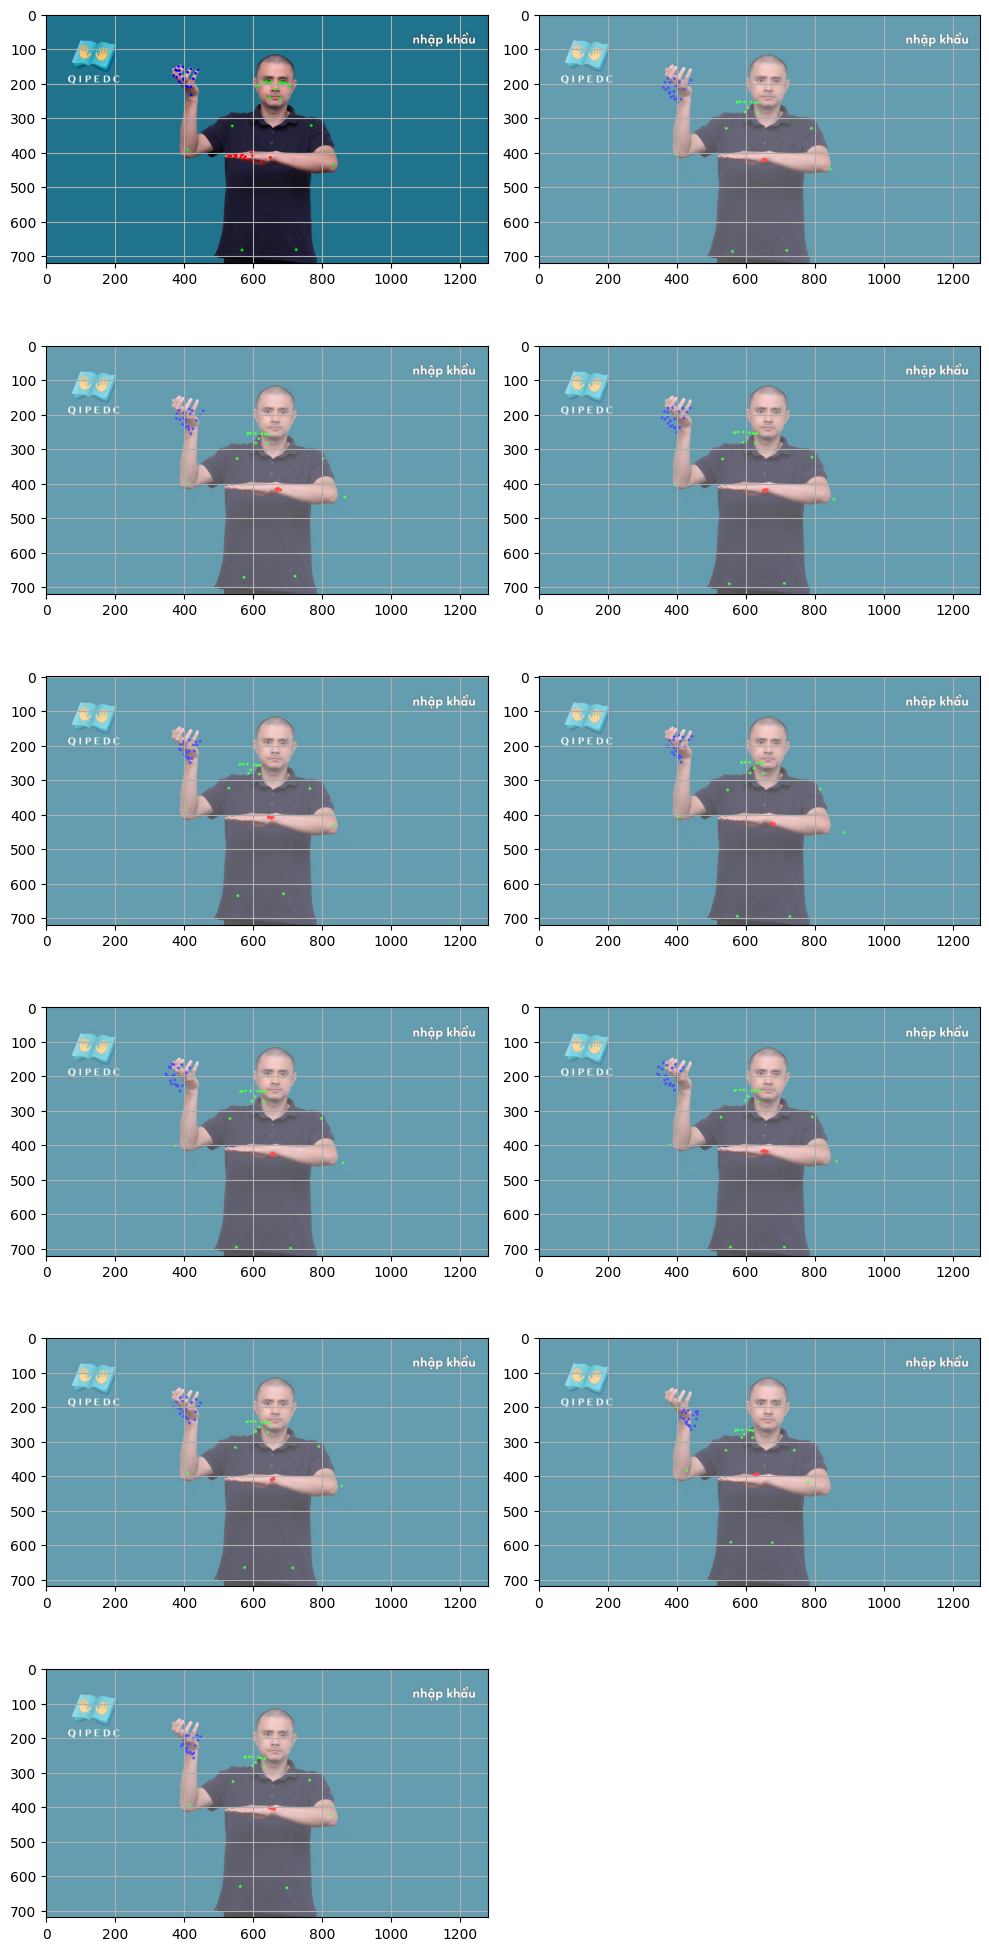

In [27]:
rows, cols = 6, 2 # grid
f_idx = 62
kps_idx = 9
plt.figure(figsize=(10, 20))
keypoints_dir = "../notebooks/dataset/visualization"
sub_dir = "augmentation"

for i in range(0, 11):
    plt.subplot(rows, cols, i+1)
    image = cv2.imread(f"../notebooks/dataset/visualization/images/frame_{f_idx}.jpg")
    
    if i == 0: # origin keypoints
        path_file = keypoints_dir + "/0.npy"
        alpha=1
    else:
        path_file = os.path.join(keypoints_dir, sub_dir) + "/" + str(i-1) + ".npy"
        print(path_file)
        alpha=0.7
    
    data = np.load(path_file, allow_pickle=True)
    # lh, rh, pose = data[0]
    lh, rh, pose = data[kps_idx]
    add_keypoints_to_image(image, pose, color=green)
    add_keypoints_to_image(image, lh, color=red)
    add_keypoints_to_image(image, rh, color=blue)
    # display_image(image, axis=True, grid=True, alpha=alpha)  
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), alpha=alpha)
    plt.axis()
    plt.grid()
        
plt.tight_layout()
plt.show()

In [90]:
from config import N_HAND_LANDMARKS, N_POSE_LANDMARKS, EPSILON_BODY, EPSILON_HAND_FINGER, EPSILON_EYE
import random
import numpy as np

K_BODY = random.uniform(0.85, 1.25)
K_FINGER = 0.9*K_BODY

def create_noise_point(point, eps):
    """Create new point displaced any epsilon from the origin point."""
    
    x, y, z = tuple(point)
    ex = random.uniform(-eps, eps)
    ey = random.uniform(-eps, eps)
    # ez = random.uniform(-0.5, 0.5)
    return [x + ex, y + ey, 0]

def create_point_by_k(A, B, M, k):
    """Create a new point M' such that vector MM' is k times vector AB."""
    xA, yA, zA = tuple(A)
    xB, yB, zB = tuple(B)
    xM, yM, zM = tuple(M)
    x = xB - xA
    y = yB - yA
    # z = zB - zA
    print(xM, "+ (", xB, "-", xA, ")*", k, "=", xM + k * x)
    print(yM, "+ (", yB, "-", yA, ")*", k, "=", yM + k * y)
    
    return [xM + k * x, yM + k *y, 0]

def distance(M1, M2):
    """Calculate euclidean distance between two points."""
    x1, y1, z1 = tuple(M1)
    x2, y2, z2 = tuple(M2)
    d = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2 + (z2 - z1) ** 2)
    return d

def calculate_k(A1, B1, M1, N1):
    """Calculate distortion coefficient k between origin frame and augmented frame."""
    d1 = distance(A1, B1)
    print("d1: ", d1)
    if d1==0: # solve no keypoint detection [0.0, 0.0, z]
        d1=1
        print("d1: ", d1)
    h1 = distance(M1, N1)
    print("h1: ", h1)
    k1 = h1 / d1
    return k1

def calculate_start_point(A1, B1, A2, B2, M1, N1):
    k0 = K_BODY
    M2 = create_point_by_k(A1, A2, M1, k0)
    k1 = calculate_k(A1, B1, M1, N1)
    N2 = create_point_by_k(A2, B2, M2, k1)
    return M2, N2

def create_next_point(A1, B1, A2, B2, M1, N1, M2):
    k1 = calculate_k(A1, B1, M1, N1)
    print("k1: ", k1)
    N2 = create_point_by_k(A2, B2, M2, k1)
    return N2

def create_frame_0(list_frames_keypoints):
    """
    Choose right_shoulder as the main point to generate other points.
    k: the global body transformation rate.
    """
    
    right_hand_result = []
    left_hand_result = []
    pose_result = [[0, 0, 0]] * N_POSE_LANDMARKS
    
    start_frame = list_frames_keypoints[0]
    # start_frame[0]: left_hand_landmarks
    # start_frame[1]: right_hand_landmarks
    # start_frame[2]: pose_landmarks
    
    point_12 = create_noise_point(start_frame[2][12], 0.01)
    k =  random.uniform(0.8, 1.2)
    point_14 = create_point_by_k(start_frame[2][12], start_frame[2][14], point_12, k)
    point_14 = create_noise_point(point_14, EPSILON_BODY)
    point_16 = create_point_by_k(start_frame[2][14], start_frame[1][0], point_14, k)
    point_16 = create_noise_point(point_16, EPSILON_BODY)
    point_1_r = create_point_by_k(start_frame[1][0], start_frame[1][1], point_16, k)
    point_1_r = create_noise_point(point_1_r, EPSILON_HAND_FINGER)
    right_hand_result.append(point_16)
    right_hand_result.append(point_1_r)
    for i in range(2, 21):
        if i % 4 != 1:
            point_r = create_point_by_k(start_frame[1][i-1], start_frame[1][i], right_hand_result[i-1], k)
            point_r = create_noise_point(point_r, EPSILON_HAND_FINGER)
            right_hand_result.append(point_r)
        else:
            if i == 5:
                point_5_r = create_point_by_k(start_frame[1][0], start_frame[1][5], right_hand_result[0], k)
                point_5_r = create_noise_point(point_5_r, EPSILON_HAND_FINGER)
                right_hand_result.append(point_5_r)
            else:
                point_r = create_point_by_k(start_frame[1][i-4], start_frame[1][i], right_hand_result[i-4], k)
                point_r = create_noise_point(point_r, EPSILON_HAND_FINGER)
                right_hand_result.append(point_r)
    
    # 11 - left_shoulder, 13 - left_elbow 
    point_11 = create_point_by_k(start_frame[2][12], start_frame[2][11], point_12, k)
    point_11 = create_noise_point(point_11, EPSILON_BODY)
    point_13 = create_point_by_k(start_frame[2][11], start_frame[2][13], point_11, k)
    point_13 = create_noise_point(point_13, EPSILON_BODY)
    # 15 - left_wrist
    point_15 = create_point_by_k(start_frame[2][13], start_frame[0][0], point_13, k)
    point_15 = create_noise_point(point_15, EPSILON_BODY)
    point_1_l = create_point_by_k(start_frame[0][0], start_frame[0][1], point_15, k)
    point_1_l = create_noise_point(point_1_l, EPSILON_HAND_FINGER)
    left_hand_result.append(point_15)
    left_hand_result.append(point_1_l)
    for i in range(2, 21):
        if i % 4 != 1:
            point_l = create_point_by_k(start_frame[0][i - 1], start_frame[0][i], left_hand_result[i - 1], k)
            point_l = create_noise_point(point_l, EPSILON_HAND_FINGER)
            left_hand_result.append(point_l)
        else:
            if i == 5:
                point_5_l = create_point_by_k(start_frame[0][0], start_frame[0][5], left_hand_result[0], k)
                point_5_l = create_noise_point(point_5_l, EPSILON_HAND_FINGER)
                left_hand_result.append(point_5_l)
            else:
                point_l = create_point_by_k(start_frame[0][i - 4], start_frame[0][i], left_hand_result[i - 4], k)
                point_l = create_noise_point(point_l, EPSILON_HAND_FINGER)
                left_hand_result.append(point_l)
    
    point_24 = create_point_by_k(start_frame[2][12], start_frame[2][16], point_12, k)
    point_23 = create_point_by_k(start_frame[2][16], start_frame[2][15], point_24, k)
    
    point_10 = create_point_by_k(start_frame[2][12], start_frame[2][10], point_12, k)
    point_9 = create_point_by_k(start_frame[2][10], start_frame[2][9], point_10, k)
    
    point_0 = create_point_by_k(start_frame[2][10], start_frame[2][0], point_10, k)
    
    point_1 = create_point_by_k(start_frame[2][0], start_frame[2][1], point_0, k)
    point_2 = create_point_by_k(start_frame[2][1], start_frame[2][2], point_1, k)
    point_3 = create_point_by_k(start_frame[2][2], start_frame[2][3], point_2, k)
    point_7 = create_point_by_k(start_frame[2][3], start_frame[2][7], point_3, k)
    
    point_4 = create_point_by_k(start_frame[2][0], start_frame[2][4], point_0, k)
    point_5 = create_point_by_k(start_frame[2][4], start_frame[2][5], point_4, k)
    point_6 = create_point_by_k(start_frame[2][5], start_frame[2][6], point_5, k)
    point_8 = create_point_by_k(start_frame[2][6], start_frame[2][8], point_6, k)
    
    list_pose_points = [point_0, point_1, point_2, point_3, point_4, point_5, point_6, point_7, point_8, point_9, point_10,
                        point_11, point_12, point_13, point_14, point_23, point_24]

    for i in range(0, 17):
        if i < 11:
            pose_result[i] = create_noise_point(list_pose_points[i], EPSILON_EYE)
        else:
            pose_result[i] = create_noise_point(list_pose_points[i], EPSILON_BODY)
            
    frame_0 = [left_hand_result, right_hand_result, pose_result]
    return frame_0
    
def create_frame_t(t, list_frames_keypoints, frame_start):
    pose_result = [[0, 0, 0]] * N_POSE_LANDMARKS
    right_hand_result = []
    left_hand_result = []
    frame_current = list_frames_keypoints[t]  # A2B2
    frame_0 = list_frames_keypoints[0]  # A1B1
    
    point_12, point_14 = calculate_start_point(frame_0[2][12], frame_0[2][14], frame_current[2][12],
                                               frame_current[2][14], frame_start[2][12], frame_start[2][14])
    point_16 = create_next_point(frame_0[2][14], frame_0[1][0], frame_current[2][14], frame_current[1][0],
                                 frame_start[2][14], frame_start[1][0], point_14)
    
    print("\npoint 11")
    point_11 = create_next_point(frame_0[2][12], frame_0[2][11], frame_current[2][12], frame_current[2][11],
                                 frame_start[2][12], frame_start[2][11], point_12)
    print("\npoint 13")
    point_13 = create_next_point(frame_0[2][11], frame_0[2][13], frame_current[2][11], frame_current[2][13],
                                 frame_start[2][11], frame_start[2][13], point_11)
    
    print("Processing left-hand")
    print("\npoint 15 - point 0 left hand")
    point_15 = create_next_point(frame_0[2][13], frame_0[0][0], frame_current[2][13], frame_current[0][0],
                                 frame_start[2][13], frame_start[0][0], point_13)
    point_24 = create_next_point(frame_0[2][12], frame_0[2][16], frame_current[2][12], frame_current[2][16],
                                 frame_start[2][12], frame_start[2][16], point_12)
    point_23 = create_next_point(frame_0[2][16], frame_0[2][15], frame_current[2][16], frame_current[2][15],
                                 frame_start[2][16], frame_start[2][15], point_24)
    point_10 = create_next_point(frame_0[2][12], frame_0[2][10], frame_current[2][12], frame_current[2][10],
                                 frame_start[2][12], frame_start[2][10], point_12)
    point_9 = create_next_point(frame_0[2][10], frame_0[2][9], frame_current[2][10], frame_current[2][9],
                                frame_start[2][10], frame_start[2][9], point_10)
    point_0 = create_next_point(frame_0[2][10], frame_0[2][0], frame_current[2][10], frame_current[2][0],
                                frame_start[2][10], frame_start[2][0], point_10)
    point_1 = create_next_point(frame_0[2][0], frame_0[2][1], frame_current[2][0], frame_current[2][1],
                                frame_start[2][0], frame_start[2][1], point_0)
    point_2 = create_next_point(frame_0[2][1], frame_0[2][2], frame_current[2][1], frame_current[2][2],
                                frame_start[2][1], frame_start[2][2], point_1)
    point_3 = create_next_point(frame_0[2][2], frame_0[2][3], frame_current[2][2], frame_current[2][3],
                                frame_start[2][2], frame_start[2][3], point_2)
    point_4 = create_next_point(frame_0[2][0], frame_0[2][4], frame_current[2][0], frame_current[2][4],
                                frame_start[2][0], frame_start[2][4], point_0)
    point_5 = create_next_point(frame_0[2][4], frame_0[2][5], frame_current[2][4], frame_current[2][5],
                                frame_start[2][4], frame_start[2][5], point_4)
    point_6 = create_next_point(frame_0[2][5], frame_0[2][6], frame_current[2][5], frame_current[2][6],
                                frame_start[2][5], frame_start[2][6], point_5)
    point_7 = create_next_point(frame_0[2][3], frame_0[2][7], frame_current[2][3], frame_current[2][7],
                                frame_start[2][3], frame_start[2][7], point_3)
    point_8 = create_next_point(frame_0[2][6], frame_0[2][8], frame_current[2][6], frame_current[2][8],
                                frame_start[2][6], frame_start[2][8], point_6)
    
    list_pose_points = [point_0, point_1, point_2, point_3, point_4, point_5, point_6, point_7, point_8, point_9, point_10,
                        point_11, point_12, point_13, point_14, point_23, point_24]
    
    for i in range(0, 17):
        if i < 11:
            pose_result[i] = create_noise_point(list_pose_points[i], EPSILON_EYE)
        else:
            pose_result[i] = create_noise_point(list_pose_points[i], EPSILON_BODY)
    
    # processing left hand
    # left_hand_result.append(point_15)
    # point_1_l = create_next_point(frame_0[0][0], frame_0[0][1], frame_current[0][0], frame_current[0][1],
    #                               frame_start[0][0], frame_start[0][1], point_15)
    # print("point 1 - origin: ", frame_current[0][1])
    # print("point 1 - create: ", point_1_l)
    # left_hand_result.append(point_1_l)
    # for i in range(2, 21):
    #     if i % 4 != 1:
    #         point_l = create_next_point(frame_0[0][i - 1], frame_0[0][i], frame_current[0][i - 1], frame_current[0][i],
    #                                     frame_start[0][i - 1], frame_start[0][i],
    #                                     left_hand_result[i - 1])
    #         point_l = create_noise_point(point_l, EPSILON_HAND_FINGER)
    #         print(f"point {i} - origin: ", frame_current[0][i])
    #         print(f"point {i} - create: ", point_l)
    #         left_hand_result.append(point_l)
    #     else:
    #         if i == 5:
    #             point_5_l = create_next_point(frame_0[0][0], frame_0[0][5], frame_current[0][0], frame_current[0][5],
    #                                           frame_start[0][0], frame_start[0][5], left_hand_result[0])
    #             point_5_l = create_noise_point(point_5_l, EPSILON_HAND_FINGER)
    #             left_hand_result.append(point_5_l)
    #         else:
    #             point_l = create_next_point(frame_0[0][i - 4], frame_0[0][i], frame_current[0][i - 4],
    #                                         frame_current[0][i],
    #                                         frame_start[0][i - 4], frame_start[0][i], left_hand_result[i - 4])
    #             point_l = create_noise_point(point_l, EPSILON_HAND_FINGER)
    #             left_hand_result.append(point_l)
    # print("End processing left-hand")
    
    # v2 huhuhu
    left_hand_result.append(point_15)
    point_1_r = create_next_point(frame_0[0][0], frame_0[0][1], frame_current[0][0], frame_current[0][1],
                                  frame_start[0][0], frame_start[0][1], point_15)
    left_hand_result.append(point_1_r)
    for i in range(2, 21):
        if i % 4 != 1:
            point_l = create_next_point(frame_0[0][i - 1], frame_0[0][i], frame_current[0][i - 1], frame_current[0][i],
                                        frame_start[0][i - 1], frame_start[0][i],
                                        left_hand_result[i - 1])
            point_l = create_noise_point(point_l, EPSILON_HAND_FINGER)
            left_hand_result.append(point_l)
        else:
            if i == 5:
                point_5_r = create_next_point(frame_0[0][0], frame_0[0][5], frame_current[0][0], frame_current[0][5],
                                              frame_start[0][0], frame_start[0][5], left_hand_result[0])
                point_5_r = create_noise_point(point_5_r, EPSILON_HAND_FINGER)
                left_hand_result.append(point_5_r)
            else:
                point_r = create_next_point(frame_0[0][i - 4], frame_0[0][i], frame_current[0][i - 4],
                                            frame_current[0][i],
                                            frame_start[0][i - 4], frame_start[0][i], left_hand_result[i - 4])
                point_r = create_noise_point(point_r, EPSILON_HAND_FINGER)
                left_hand_result.append(point_r)
    
    right_hand_result.append(point_16)
    point_1_r = create_next_point(frame_0[1][0], frame_0[1][1], frame_current[1][0], frame_current[1][1],
                                  frame_start[1][0], frame_start[1][1], point_16)
    right_hand_result.append(point_1_r)
    for i in range(2, 21):
        if i % 4 != 1:
            point_r = create_next_point(frame_0[1][i - 1], frame_0[1][i], frame_current[1][i - 1], frame_current[1][i],
                                        frame_start[1][i - 1], frame_start[1][i],
                                        right_hand_result[i - 1])
            point_r = create_noise_point(point_r, EPSILON_HAND_FINGER)
            right_hand_result.append(point_r)
        else:
            if i == 5:
                point_5_r = create_next_point(frame_0[1][0], frame_0[1][5], frame_current[1][0], frame_current[1][5],
                                              frame_start[1][0], frame_start[1][5], right_hand_result[0])
                point_5_r = create_noise_point(point_5_r, EPSILON_HAND_FINGER)
                right_hand_result.append(point_5_r)
            else:
                point_r = create_next_point(frame_0[1][i - 4], frame_0[1][i], frame_current[1][i - 4],
                                            frame_current[1][i],
                                            frame_start[1][i - 4], frame_start[1][i], right_hand_result[i - 4])
                point_r = create_noise_point(point_r, EPSILON_HAND_FINGER)
                right_hand_result.append(point_r)
                
    return [left_hand_result, right_hand_result, pose_result]

In [91]:
src = np.load("../notebooks/dataset/visualization/0.npy", allow_pickle=True)
source_sample = src.copy()
print("ORIGIN ======================:")
print("Frame 0:")
print("Left-hand: \n", source_sample[0][0])
print("Right-hand: \n", source_sample[0][1])
# path_to_save = "../notebooks/dataset/visualization/augmentation"
# os.makedirs(path_to_save, exist_ok=True)

try:
    new_file = path_to_save + "/" + str(index) + ".npy"
    result = []
    frame_0 = create_frame_0(source_sample)
    print("\nAUG ======================:")
    print("Frame 0:")
    print("Left-hand: \n", frame_0[0])
    print("Right-hand: \n", frame_0[1])
    result.append(frame_0)
    
    print("Create next frame")
    frame_i = create_frame_t(9, source_sample, frame_0)
    result.append(frame_i)
    print("\nORIGIN ======================:")
    print("Frame 9:")
    print("Left-hand: \n", source_sample[9][0])
    print("Right-hand: \n", source_sample[9][1])

    print("\nAUG ======================:")
    print("Left-hand: \n", frame_i[0])
    print("Right-hand: \n", frame_i[1])
    data_save = np.asarray(result, dtype="object")
except Exception as e:
    print(f"error when generate augmented data: {e}.")
    

ORIGIN ======================:
Frame 0:
Left-hand: 
 [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
Right-hand: 
 [[0.39153775572776794, 1.0017980337142944, 2.0740063177981938e-07], [0.3944830596446991, 0.9870507717132568, -0.029892293736338615], [0.3957335352897644, 0.9806971549987793, -0.05270175263285637], [0.38910382986068726, 0.9621056318283081, -0.07102058827877045], [0.3824978768825531, 0.9335428476333618, -0.0901484340429306], [0.39408108592033386, 1.0436925888061523, -0.05063609033823013], [0.39549264311790466, 1.0700762271881104, -0.06730026006698608], [0.39596837759017944, 1.087463140487671, -0.07788684219121933], [0.39579886198043823, 1.100448727607727, -0.085088908672

In [96]:
frame_0_origin = src.copy()[0]
frame_i_origin = src.copy()[9]

lh_frame_i_origin = frame_i_origin[0]
print("Frame 9 ORIGIN")
for i, value in enumerate(lh_frame_i_origin):
    x, y, _ = value
    print(f"point {i}: ", "x =", x, "y =", y)
    
frame_0_aug = frame_0.copy()
frame_i_aug = frame_i.copy()
lh_frame_i_aug = frame_i_aug[0]
print("\nFrame 9 AUG")
for i, value in enumerate(lh_frame_i_aug):
    x, y, _ = value
    print(f"point {i}: ", "x =", x, "y =", y)

Frame 9 ORIGIN
point 0:  x = 0.5074782967567444 y = 0.5763295292854309
point 1:  x = 0.4870145618915558 y = 0.595551609992981
point 2:  x = 0.46905317902565 y = 0.5904938578605652
point 3:  x = 0.45686012506484985 y = 0.5842271447181702
point 4:  x = 0.44762134552001953 y = 0.5794453620910645
point 5:  x = 0.4633566737174988 y = 0.5584977269172668
point 6:  x = 0.44470250606536865 y = 0.5638151168823242
point 7:  x = 0.43064361810684204 y = 0.5679644346237183
point 8:  x = 0.4185958206653595 y = 0.5702482461929321
point 9:  x = 0.4641354978084564 y = 0.5556173920631409
point 10:  x = 0.44228455424308777 y = 0.5625326037406921
point 11:  x = 0.4269716441631317 y = 0.5673646330833435
point 12:  x = 0.4126465618610382 y = 0.5692925453186035
point 13:  x = 0.4657149314880371 y = 0.5595625042915344
point 14:  x = 0.44389933347702026 y = 0.5656248927116394
point 15:  x = 0.4291662573814392 y = 0.5693829655647278
point 16:  x = 0.41602903604507446 y = 0.5701645016670227
point 17:  x = 0.46735

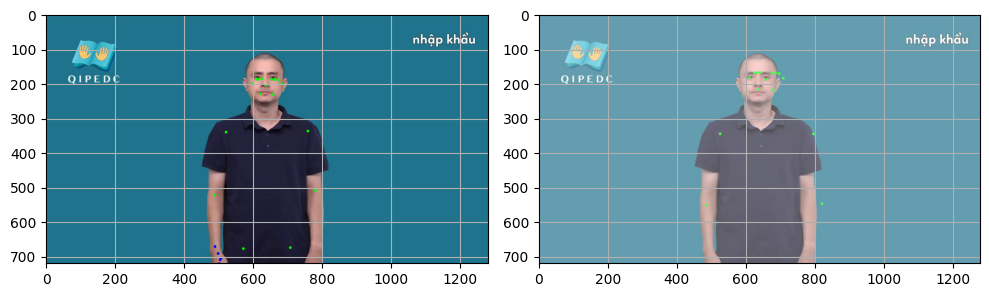

In [101]:
rows, cols = 1, 2 # grid
f_idx = 0
kps_idx = 0
plt.figure(figsize=(10, 20))
keypoints_dir = "../notebooks/dataset/visualization"
sub_dir = "augmentation"

for i in range(0, 2):
    plt.subplot(rows, cols, i+1)
    image = cv2.imread(f"../notebooks/dataset/visualization/images/frame_{f_idx}.jpg")
    
    if i == 0: # origin keypoints
        data = frame_0_origin
        alpha=1
    else:
        data = frame_0_aug
        alpha=0.7
    
    # lh, rh, pose = data[0]
    lh, rh, pose = data
    add_keypoints_to_image(image, pose, color=green)
    add_keypoints_to_image(image, lh, color=red)
    add_keypoints_to_image(image, rh, color=blue)
    # display_image(image, axis=True, grid=True, alpha=alpha)  
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), alpha=alpha)
    plt.axis()
    plt.grid()
        
plt.tight_layout()
plt.show()

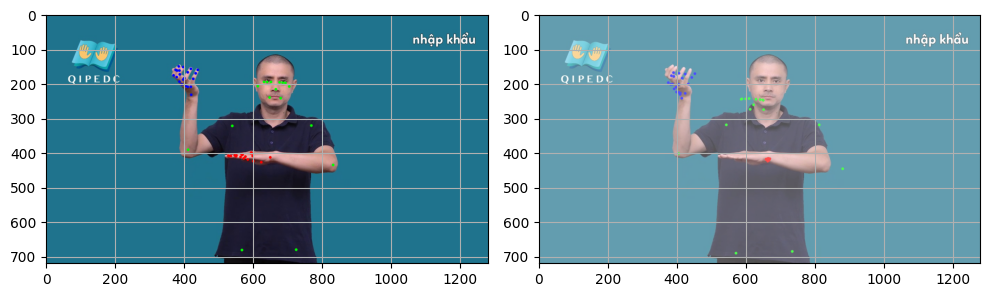

In [99]:
rows, cols = 1, 2 # grid
f_idx = 62
kps_idx = 9
plt.figure(figsize=(10, 20))
keypoints_dir = "../notebooks/dataset/visualization"
sub_dir = "augmentation"

for i in range(0, 2):
    plt.subplot(rows, cols, i+1)
    image = cv2.imread(f"../notebooks/dataset/visualization/images/frame_{f_idx}.jpg")
    
    if i == 0: # origin keypoints
        data = frame_i_origin
        alpha=1
    else:
        data = frame_i_aug
        alpha=0.7
    
    # lh, rh, pose = data[0]
    lh, rh, pose = data
    add_keypoints_to_image(image, pose, color=green)
    add_keypoints_to_image(image, lh, color=red)
    add_keypoints_to_image(image, rh, color=blue)
    # display_image(image, axis=True, grid=True, alpha=alpha)  
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), alpha=alpha)
    plt.axis()
    plt.grid()
        
plt.tight_layout()
plt.show()